In [1]:
# Set up working environment
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import pandas as pd
import numpy as np
import os
import shutil
import maboss
#import ginsim

## Toy model at the single-cell level

The following introduces a toy model accounting for a cellular receptor (R) which can activate competing downstream components (B through T, or A directly). B can further activate the component C, but only in absence of T, which is upstream of B.

In [2]:
# Set up the required files
bnd_file ="ToyModelUP.bnd"
cfg_file = "ToyModelUP.cfg"

In [3]:
model_maboss = maboss.load(bnd_file,cfg_file)
maboss.set_output(model_maboss, ["T", "A", "B", "C", "R"])
model_maboss.print_bnd()

Node Bi {


	rate_up = $u_Bi;
	rate_down = $d_Bi;
}
Node R {


	rate_up = 0;
	rate_down = 1;
}

Node T {

	logic = (R | B);
	rate_up = @logic ? 1.0 : 0.0;
	rate_down = @logic ? 0.0 : 1.0;
}

Node A {

	logic = (A|R) & (!C) & (!B);
	rate_up = @logic ? 1.0 : 0.0;
	rate_down = @logic ? 0.0 : 1.0;
}

Node B {

	logic = (T & (!A));
	rate_up = @logic ? 1.0 : 0.0;
	rate_down = @logic ? 0.0 : 1.0;
}

Node C {

	logic = (C | B | Bi) & !A & !T;
	rate_up = @logic ? 1.0 : 0.0;
	rate_down = @logic ? 0.0 : 1.0;
}


We then show that a simulation starting with the receptor R active can lead to the exclusive activation of A or B, unless the receptor is disabled first, which leads to a naive state. 
In this configuration, C can never be activated.

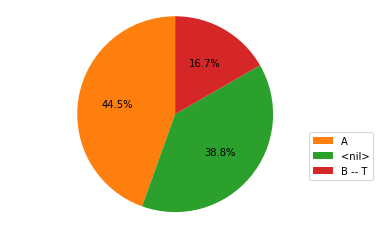

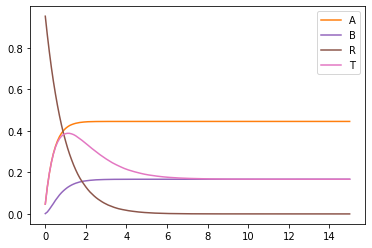

In [4]:
r = model_maboss.run()

# Plot the piechart and trajectories
r.plot_piechart()
r.plot_node_trajectory(until=15)

# save pdf versions of the plots
r._piefig.savefig("single_pie.pdf")
r._ndtraj.savefig("single_traj.pdf")

## Add rules for the population

Here we extend the previous model to take into account an additional population effect: when a cell produces B, it can be secreted and act on neighbour cells as well (through receptor Bi).
As these other cells may not have an active T component, B will then be able to activate C in these cells.

We show that this effect leads to the replacement of naive cells with cells expressing C. 
The cells expressing C could not be predicted by the single-cell model, however, they are widespread in the population.


In [5]:
upp_file = "ToyModelUP.upp"
model_maboss.update_parameters(max_time=1)
model_upmaboss = maboss.UpdatePopulation(model_maboss, upp_file)
ufile = open(upp_file, 'r') 
print(ufile.read())
ufile.close()

$u_Bi u= p[(B) = (1)];
steps = 10;
MaBoSS = MaBoSS;


CPU times: user 534 ms, sys: 639 ms, total: 1.17 s
Wall time: 1min 46s


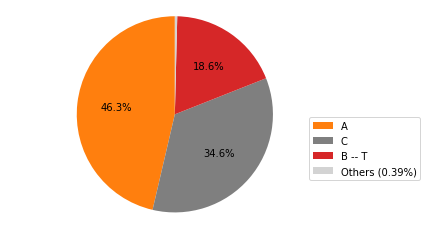

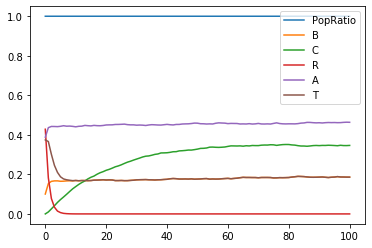

In [6]:

model_upmaboss.setStepNumber(100)
%time ur = model_upmaboss.run()

ur.results[-1].plot_piechart()
ur.results[-1]._piefig.savefig("fast_pop_pie.pdf")

traj = ur.get_nodes_stepwise_probability_distribution()
p = traj.plot()
p.get_figure().savefig("fast_pop_traj.pdf")